# CENG-463 Machine Learning Project 

# Image Classification using Machine Learning methods

Group 2 <br>
17050111041 - Eray Şahin <br> 
17050111021 - Kazım Muhammet Temiz <br> 
19050551004 - Ahmet Kağan Bildirici

In [1]:
import tarfile
import numpy as np 
import pandas as pd
import glob
import seaborn as sns
import cv2
import json
from skimage.feature import hog
from matplotlib import pyplot as plt

## Capture images and labels into arrays.

In [2]:
#Resize images to
SIZE = 128
READ_SIZE = 2068

In [43]:
#Read labels 
labels = pd.read_csv('flowers_labels.txt', header = None)
train_labels = np.array(labels)[:READ_SIZE] #ilk READ_SIZE label

In [4]:
#Read flower data into np array
images= []
files = glob.glob ("/Users/Kazim/Desktop/mlproj/segmente/*.jpg")
i = 0
for myFile in files:
    img = cv2.imread (myFile)
    img = cv2.resize(img, (SIZE, SIZE))
    images.append (img)
    i += 1
    if i == READ_SIZE:
        break


In [5]:
images = np.array(images)

<function matplotlib.pyplot.show(close=None, block=None)>

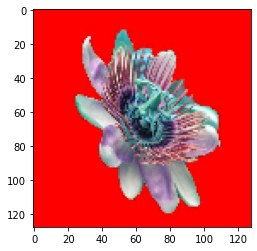

In [6]:
#Test if we have the images or not
plt.imshow(images[7], cmap='gray')
plt.grid(False)
plt.show

In [17]:
images.shape

(2068, 128, 128, 3)

In [27]:
train_labels.shape

(1988,)

## Bag of Words

In computer vision, the bag-of-words model (BoW model) sometimes called bag-of-visual-words model can be applied to image classification or retrieval, by treating image features as words.A bag of visual words is a vector of occurrence counts of a vocabulary of local image features.

In [45]:
#Descriptor lists
des_list_sift=[]
des_list_orb=[]
des_list_brief=[]

#Feature extractors
sift = cv2.xfeatures2d.SIFT_create()
orb=cv2.ORB_create()
fast = cv2.FastFeatureDetector_create() 
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

#Some segmentation images have no data, so we drop them from the data. 
#To match the labels we must also drop the corresponding label too.
new_labels = []

counter = 0

for img in images:
    kp_sift = sift.detect(img,None)
    keypoints_sift,descriptor_sift= sift.compute(img, kp_sift)
    
    kp_orb=orb.detect(img,None)
    keypoints_orb,descriptor_orb= orb.compute(img, kp_orb)
    
    kp_fast = fast.detect(img, None)
    keypoints_brief, descriptor_brief = brief.compute(img, kp_fast)
    
    if(descriptor_sift is not None and descriptor_orb is not None and descriptor_brief is not None):
        des_list_sift.append((img,descriptor_sift))
        des_list_orb.append((img,descriptor_orb))
        des_list_brief.append((img,descriptor_brief))
        new_labels.append(train_labels[counter])

    counter+=1



In [48]:
train_labels = np.array(new_labels)

In [50]:
#Stack the descriptors from descriptor lists

descriptors_sift=des_list_sift[0][1]
for image_path,descriptor in des_list_sift[1:]:
    descriptors_sift=np.vstack((descriptors_sift,descriptor))
        
descriptors_orb=des_list_orb[0][1]
for image_path,descriptor in des_list_orb[1:]:
    descriptors_orb=np.vstack((descriptors_orb,descriptor))

descriptors_brief=des_list_brief[0][1]
for image_path,descriptor in des_list_brief[1:]:
    descriptors_brief=np.vstack((descriptors_brief,descriptor))


In [51]:
descriptors_sift.shape

(145884, 128)

In [52]:
descriptors_orb.shape

(288768, 32)

In [53]:
descriptors_brief.shape

(355240, 32)

In [54]:
#Change descriptor type to float

descriptors_sift_float=descriptors_sift.astype(float)
descriptors_orb_float=descriptors_orb.astype(float)
descriptors_brief_float=descriptors_brief.astype(float)
descriptors_sift_float.shape

(145884, 128)

## K Means clustering on descriptors

We make clusters from the descriptors (K-Means). The center of each cluster will be used as the words.

In [55]:
from scipy.cluster.vq import kmeans,vq

In [56]:
k_sift=3000
k_orb=2000
k_brief=1000
voc_sift,variance_sift = kmeans(descriptors_sift_float,k_sift,1)
voc_orb,variance_orb = kmeans(descriptors_orb_float,k_orb,1)
voc_brief,variance_brief = kmeans(descriptors_brief_float,k_brief,1)

## Creating histogram of training image

Finally, for each image, we make frequency histogram from the words and the frequency of the words in the image. Those histograms are our bag of visual words.

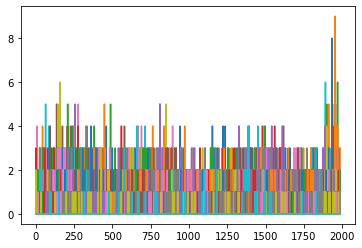

In [57]:
#Feature arrays
im_features_sift=np.zeros((len(des_list_orb),k_sift),"float32")
im_features_orb=np.zeros((len(des_list_orb),k_orb),"float32")
im_features_brief=np.zeros((len(des_list_orb),k_brief),"float32")

#Create the histogram
for i in range(len(des_list_orb)):
    words_sift,distance_sift=vq(des_list_sift[i][1],voc_sift)
    words_orb,distance_orb=vq(des_list_orb[i][1],voc_orb)
    words_brief,distance_brief=vq(des_list_brief[i][1],voc_brief)
    for w in words_brief:
        im_features_brief[i][w]+=1
    for w in words_sift:
        im_features_sift[i][w]+=1
    for w in words_orb:
        im_features_orb[i][w]+=1
        
plt.plot(im_features_sift);

In [58]:
im_features_sift.shape

(1988, 3000)

In [59]:
im_features_orb.shape

(1988, 2000)

In [60]:
im_features_brief.shape

(1988, 1000)

## Applying standardisation on training feature

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
stdslr=StandardScaler().fit(im_features_sift)
im_features_sift=stdslr.transform(im_features_sift)

In [63]:
stdslr=StandardScaler().fit(im_features_orb)
im_features_orb=stdslr.transform(im_features_orb)

In [64]:
stdslr=StandardScaler().fit(im_features_brief)
im_features_brief=stdslr.transform(im_features_brief)

## PCA on image features

### PCA on SIFT

In [65]:
from sklearn.decomposition import PCA

In [236]:
numComponents = 10
pca = PCA(n_components=numComponents)
pca.fit(im_features_sift)

pca_im_features_sift = pca.transform(im_features_sift)
pca_im_features_sift = pd.DataFrame(pca_im_features_sift)
pca_im_features_sift

,0,1,2,3,4,5,6,7,8,9
0,8.806161,-3.314245,-15.444377,1.831611,12.153599,-3.734717,8.126858,3.853909,7.605764,7.097804
1,4.376059,-2.128170,-4.061565,-0.826499,-0.117226,1.432461,-1.075199,-0.144498,-2.531723,-1.973724
2,-4.413237,-1.986779,1.787827,-0.237634,1.334649,-0.867954,-1.711532,0.596021,0.154052,-0.408097
3,1.097838,2.150969,-6.299390,-1.187555,1.165878,-1.389591,3.064321,5.722569,-0.176932,-1.880661
4,5.939809,-4.772231,-12.931232,1.922309,13.885612,1.720834,4.456066,-2.324872,-0.675888,3.207147
...,...,...,...,...,...,...,...,...,...,...
1983,-4.565490,-3.387376,1.842228,-1.194103,0.409670,1.955089,-0.852097,0.769039,0.268647,-0.213667
1984,-3.874916,-2.171780,1.291366,2.341053,-0.537754,1.595973,-1.013666,-0.004323,0.825634,-0.341566
1985,-3.815764,-3.525980,2.422631,1.923814,0.272136,1.403496,-1.413448,1.065029,-0.425858,-0.364517
1986,-3.305210,-3.110386,2.433221,1.094197,0.619124,1.797254,-0.136095,0.974025,0.233408,0.628855


### PCA on ORB

In [237]:
numComponents = 10
pca = PCA(n_components=numComponents)
pca.fit(im_features_orb)

pca_im_features_orb = pca.transform(im_features_orb)
pca_im_features_orb = pd.DataFrame(pca_im_features_orb)
pca_im_features_orb

,0,1,2,3,4,5,6,7,8,9
0,13.814534,7.146351,-6.320279,-12.426372,-2.433234,4.302084,13.698050,13.170823,8.801660,-6.112360
1,8.676222,-1.008144,-0.456306,-1.211965,1.337343,2.333231,0.232889,-2.887403,0.223185,-1.904435
2,-6.468096,-6.666475,-0.487363,2.520976,1.845067,1.708908,-0.406299,1.474592,2.657178,2.732340
3,9.679399,-1.153694,2.302614,-10.076068,2.026026,5.261556,-5.277465,-1.448015,-0.474671,5.135346
4,13.084224,1.969488,-7.822011,-10.575963,2.552759,2.374515,1.017054,3.201596,5.885386,-1.774627
...,...,...,...,...,...,...,...,...,...,...
1983,-4.007742,-3.977721,-4.087854,0.159343,-0.253676,0.649559,0.371981,-1.341375,1.582205,0.915203
1984,-3.825887,-3.760458,0.003144,-2.087959,-1.286686,-0.395383,3.130224,-2.214424,0.013988,-3.391858
1985,-2.802851,-9.062683,8.473634,0.001422,1.173262,0.771497,2.217352,-2.293073,2.851391,-4.823942
1986,-4.903259,-5.262912,-1.801937,2.005267,-2.537644,1.712702,1.509074,-0.219407,0.559103,2.052235


### PCA on BRIEF

In [254]:
numComponents = 15
pca = PCA(n_components=numComponents)
pca.fit(im_features_brief)

pca_im_features_brief = pca.transform(im_features_brief)
pca_im_features_brief = pd.DataFrame(pca_im_features_brief)
pca_im_features_brief

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,15.377115,6.315036,1.524248,-3.921860,-6.805103,1.231570,5.200929,0.629547,-7.035841,-6.162469,4.885649,4.949161,-3.213283,-1.088984,1.972035
1,8.913307,7.863046,-0.844337,1.472447,3.280826,0.029923,2.368216,-4.424523,-4.980847,-1.289183,-3.410390,-0.616290,-1.437072,-2.752445,0.388280
2,-6.462274,-0.598232,-0.587407,-0.193159,-0.663495,2.592561,-1.013431,0.775167,-0.855171,0.311558,-0.818378,-1.107030,-1.700824,0.299414,-0.183791
3,1.990832,15.373219,-3.793159,-1.870584,4.687462,0.940453,4.338967,1.658463,-7.040769,3.442481,-0.073505,2.737522,8.106239,0.950337,-3.501611
4,11.855756,2.702386,1.626662,-3.763665,-7.614357,7.788493,1.602007,-1.314098,-4.477251,-2.315132,4.366141,-1.110769,3.521111,-0.165460,-0.320634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,-4.287353,-0.489919,-0.647726,-1.698935,-0.456092,3.342298,0.145517,-0.034089,-0.539824,-0.375460,0.344658,0.840004,-2.033720,0.060628,-0.830810
1984,-2.337167,4.731141,-7.455460,-2.638611,1.600696,1.184731,-1.004212,-1.830742,2.163449,-2.020383,-0.220881,1.474122,3.667629,-0.105051,-4.005550
1985,-5.912148,2.085061,-6.843594,0.326416,-0.055649,-0.379060,-0.584976,1.353853,0.857072,-2.143499,-0.586266,0.105239,-1.903578,1.991720,1.189260
1986,-4.607121,-0.252618,-0.460859,-1.727821,-0.608946,2.058201,2.299951,0.957759,-0.221268,0.498256,-0.097940,-1.409559,-2.094834,-0.149529,-0.197961


## Concat PCA results

In [255]:
im_features = pd.concat([pca_im_features_sift,pca_im_features_orb,pca_im_features_brief],axis=1)
im_features.columns = range(0,len(im_features.columns))
im_features

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,8.806161,-3.314245,-15.444377,1.831611,12.153599,-3.734717,8.126858,3.853909,7.605764,7.097804,...,1.231570,5.200929,0.629547,-7.035841,-6.162469,4.885649,4.949161,-3.213283,-1.088984,1.972035
1,4.376059,-2.128170,-4.061565,-0.826499,-0.117226,1.432461,-1.075199,-0.144498,-2.531723,-1.973724,...,0.029923,2.368216,-4.424523,-4.980847,-1.289183,-3.410390,-0.616290,-1.437072,-2.752445,0.388280
2,-4.413237,-1.986779,1.787827,-0.237634,1.334649,-0.867954,-1.711532,0.596021,0.154052,-0.408097,...,2.592561,-1.013431,0.775167,-0.855171,0.311558,-0.818378,-1.107030,-1.700824,0.299414,-0.183791
3,1.097838,2.150969,-6.299390,-1.187555,1.165878,-1.389591,3.064321,5.722569,-0.176932,-1.880661,...,0.940453,4.338967,1.658463,-7.040769,3.442481,-0.073505,2.737522,8.106239,0.950337,-3.501611
4,5.939809,-4.772231,-12.931232,1.922309,13.885612,1.720834,4.456066,-2.324872,-0.675888,3.207147,...,7.788493,1.602007,-1.314098,-4.477251,-2.315132,4.366141,-1.110769,3.521111,-0.165460,-0.320634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,-4.565490,-3.387376,1.842228,-1.194103,0.409670,1.955089,-0.852097,0.769039,0.268647,-0.213667,...,3.342298,0.145517,-0.034089,-0.539824,-0.375460,0.344658,0.840004,-2.033720,0.060628,-0.830810
1984,-3.874916,-2.171780,1.291366,2.341053,-0.537754,1.595973,-1.013666,-0.004323,0.825634,-0.341566,...,1.184731,-1.004212,-1.830742,2.163449,-2.020383,-0.220881,1.474122,3.667629,-0.105051,-4.005550
1985,-3.815764,-3.525980,2.422631,1.923814,0.272136,1.403496,-1.413448,1.065029,-0.425858,-0.364517,...,-0.379060,-0.584976,1.353853,0.857072,-2.143499,-0.586266,0.105239,-1.903578,1.991720,1.189260
1986,-3.305210,-3.110386,2.433221,1.094197,0.619124,1.797254,-0.136095,0.974025,0.233408,0.628855,...,2.058201,2.299951,0.957759,-0.221268,0.498256,-0.097940,-1.409559,-2.094834,-0.149529,-0.197961


## Split data into test and train datasets

In [256]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(im_features,train_labels,random_state=42,test_size=0.33)
print(f"X_train shape : {X_train.shape}\nX_test shape : {X_test.shape}\ny_train shape : {y_train.shape}\ny_test shape : {y_test.shape}\n ")

X_train shape : (1331, 35)
X_test shape : (657, 35)
y_train shape : (1331, 1)
y_test shape : (657, 1)
 


## XGBoost 

In [257]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier().fit(X_train,y_train.ravel())

C:\Users\Kazim\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:47:43] WARNING: D:\bld\xgboost-split_1643227225381\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## RandomForest

In [258]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=250,random_state = 123)
classifier.fit(X_train, y_train)
test_accuracy = classifier.score(X_test, y_test)

<ipython-input-258-e14c7cb21d2d>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


# Results

In [259]:
from sklearn import metrics

In [260]:
y_pred = xgb_model.predict(X_test)
accuracy=metrics.accuracy_score(y_test,y_pred)
print(f"XGB accuracy is : {accuracy}")

XGB accuracy is : 0.6225266362252664


In [261]:
print(f"Random forest accuracy is :{test_accuracy}")

Random forest accuracy is :0.669710806697108
